# CPA Attack on Dataset 1

## Step 1: Process the traces

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Data directory
workdir = "data/dataset1"
# Number of plaintexts/traces
num_traces = 150
# Number of samples per trace
num_samples = 50000
# Number of key bytes
num_key_bytes = 16

# Initialize a 3D NumPy array to hold all traces
# Dimensions: 16 key bytes x 150 traces x 50000 samples
all_traces = np.zeros((num_key_bytes, num_traces, num_samples), dtype=float)

# Read the traces
for i in range(num_key_bytes):
    filename = f'{workdir}/trace{i}.txt'
    with open(filename, 'r') as file:
        for j, line in enumerate(file):
            # Convert line to float values and store in array
            all_traces[i, j] = np.array(line.strip().split(), dtype=float)
    i+=1

In [7]:
print(all_traces)

# Normalize each trace to have zero mean and unit variance
for i in range(num_key_bytes):
    for j in range(num_traces):
        trace = all_traces[i, j]
        mean = np.mean(trace)
        std = np.std(trace)
        all_traces[i, j] = (trace - mean) / std if std != 0 else trace

print(all_traces)

sample_trace = all_traces[0, 0]
print("Mean of the sample trace:", np.mean(sample_trace))
print("Standard deviation of the sample trace:", np.std(sample_trace))

[[[21337.6 19891.2 20467.2 ... 20812.8 20876.8 19379.2]
  [20595.2 19161.6 20211.2 ... 20812.8 20774.4 20390.4]
  [20428.8 21491.2 19814.4 ... 20620.8 20339.2 20480. ]
  ...
  [20953.6 20326.4 20556.8 ... 20531.2 20697.6 21094.4]
  [21696.  19520.  20006.4 ... 20044.8 20876.8 19852.8]
  [20044.8 20659.2 21465.6 ... 21427.2 20249.6 20070.4]]

 [[20787.2 20518.4 19827.2 ... 19916.8 20339.2 20262.4]
  [21068.8 19110.4 19916.8 ... 20108.8 20454.4 20441.6]
  [20249.6 20288.  21132.8 ... 20108.8 20492.8 21580.8]
  ...
  [19545.6 21184.  19507.2 ... 20403.2 20582.4 20531.2]
  [20454.4 20467.2 20288.  ... 20633.6 20467.2 20121.6]
  [19571.2 20275.2 19353.6 ... 20134.4 20006.4 19878.4]]

 [[20492.8 20428.8 21440.  ... 21094.4 19776.  20352. ]
  [19916.8 20684.8 20006.4 ... 21798.4 19302.4 20889.6]
  [19699.2 20032.  19814.4 ... 20364.8 19942.4 19929.6]
  ...
  [20761.6 18956.8 20556.8 ... 21094.4 20672.  20160. ]
  [21094.4 20262.4 19968.  ... 21376.  20313.6 20838.4]
  [19596.8 20288.  20812.8

In [8]:
# Initialize a 2D NumPy array for plaintexts
# Dimensions: 150 plaintexts x 16 bytes
plaintexts = np.zeros((num_traces, num_key_bytes), dtype=int)

# Read the plaintexts
with open(f'{workdir}/cleartext.txt', 'r') as file:
    for i, line in enumerate(file):
        # Convert line to integer values and store in array
        plaintexts[i] = np.array(line.strip().split(), dtype=int)

In [9]:
print(plaintexts)

[[ 39 168  54 ... 241 187 168]
 [ 96 159 181 ...  35 126 128]
 [200 109 154 ...  61 208 225]
 ...
 [255  26 167 ... 246 220 135]
 [144  60  59 ...  66  40 144]
 [205 250 179 ... 217  14 126]]


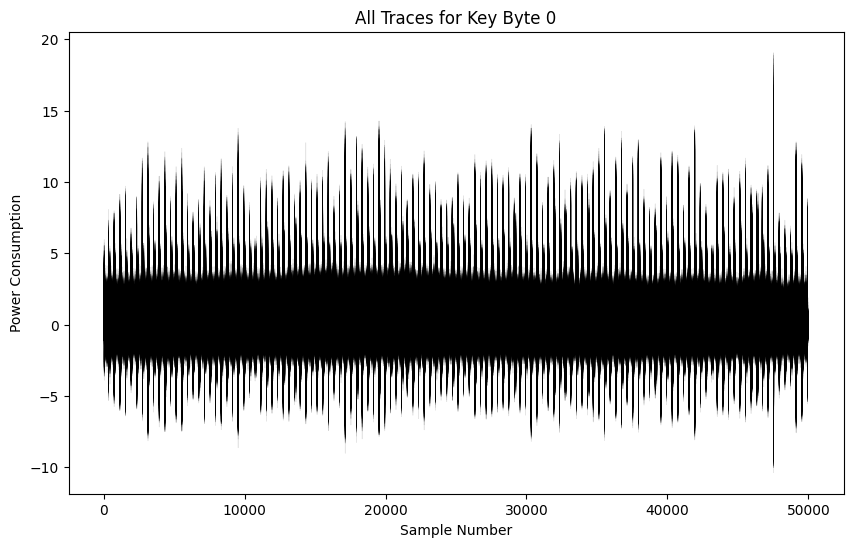

In [10]:
# plot all traces of a specific key byte
key_byte_index = 0 
plt.figure(figsize=(10, 6))

for trace in all_traces[key_byte_index]:
    plt.plot(trace, 'k', linewidth=0.5, alpha=0.1)

plt.title(f'All Traces for Key Byte {key_byte_index}')
plt.xlabel('Sample Number')
plt.ylabel('Power Consumption')
plt.show()

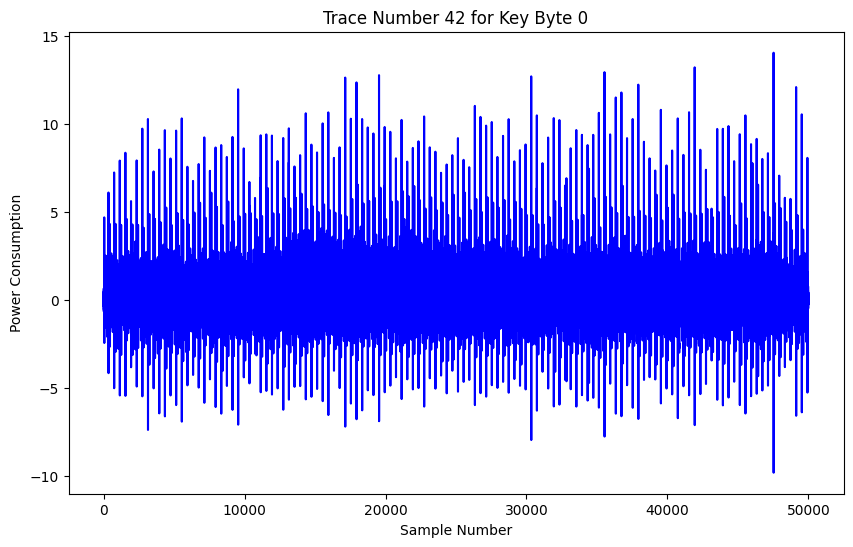

In [11]:
# plot a single trace of a specific key byte
trace_number = 41

plt.figure(figsize=(10, 6))
plt.plot(all_traces[key_byte_index][trace_number], 'b')

plt.title(f'Trace Number {trace_number + 1} for Key Byte {key_byte_index}')
plt.xlabel('Sample Number')
plt.ylabel('Power Consumption')
plt.show()

## Step 2: Generate Hypotheses

For each possible key byte value (0x00 to 0xFF), we need to calculate what the output of the AES S-box would be after the first AddRoundKey operation for each plaintext

In [12]:
# from Crypto.Cipher import AES

In [13]:
def hamming_weight(array):
    # Convert the array to uint8 if not already
    array_uint8 = array.astype(np.uint8)
    # Unpack bits; np.unpackbits expands the innermost axis
    # We need to ensure the correct axis is expanded and summed
    unpacked_bits = np.unpackbits(array_uint8, axis=2)  # This will change the shape from (150, 16, 256) to (150, 16, 256*8)
    # Sum across the last axis which has the unpacked bits
    hamming_weights = unpacked_bits.reshape(150, 16, 256, 8).sum(axis=-1)  # Reshape and sum across the actual bit axis
    return hamming_weights

# AES S-box
sbox = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

key_guesses = np.arange(256)
plaintexts_expanded = np.expand_dims(plaintexts, axis=2)
all_key_guesses = key_guesses.reshape((1, 1, 256))
sbox_input = np.bitwise_xor(plaintexts_expanded, all_key_guesses)

# Lookup in the S-box and ensure type is uint8
sbox_output = sbox[sbox_input].astype(np.uint8)

# Applying hamming_weight function
hamming_weights = hamming_weight(sbox_output)

# Checking the result
print(hamming_weights.shape)  # Expect (150, 16, 256)
print(hamming_weights[0, 0])  # Look at the first result to check range

(150, 16, 256)
[4 7 6 4 3 4 7 6 3 3 4 4 5 5 4 3 4 2 4 2 4 3 5 1 5 4 4 6 4 1 2 3 4 6 5 5 6
 6 5 4 5 5 6 7 4 5 1 2 4 4 4 6 6 4 2 4 2 4 3 4 6 3 4 5 3 4 4 3 7 4 7 3 3 6
 4 2 7 1 6 3 6 3 5 3 5 1 4 3 4 6 8 1 2 5 5 5 2 4 5 4 3 3 3 2 2 5 5 3 5 5 5
 3 5 4 6 1 6 0 4 4 6 3 3 3 4 6 5 4 4 2 2 3 2 4 3 3 5 4 4 3 3 4 5 3 4 4 5 4
 5 5 3 6 1 5 5 4 5 5 4 4 4 2 5 6 5 3 2 5 5 3 5 3 5 6 5 3 2 2 3 2 5 5 2 2 6
 3 5 6 2 4 6 3 3 4 5 4 2 3 5 4 7 2 4 5 5 4 4 5 3 2 5 7 3 3 3 3 3 6 3 3 4 4
 4 2 4 4 4 3 4 3 4 5 3 4 6 4 5 4 6 4 3 6 2 2 4 5 5 3 5 4 3 3 5 5 4 3]


[[[4 7 6 ... 5 4 3]
  [3 5 4 ... 6 4 5]
  [2 4 2 ... 5 4 6]
  ...
  [3 3 3 ... 7 5 5]
  [5 5 4 ... 4 5 4]
  [3 5 4 ... 6 4 5]]

 [[3 7 4 ... 5 3 6]
  [6 3 5 ... 4 7 3]
  [5 4 4 ... 3 5 5]
  ...
  [3 4 7 ... 4 3 3]
  [6 4 1 ... 5 5 2]
  [5 2 3 ... 8 6 4]]

 [[4 6 4 ... 4 2 4]
  [4 2 3 ... 2 5 5]
  [4 2 3 ... 3 3 4]
  ...
  [4 6 5 ... 5 4 3]
  [3 5 5 ... 4 3 3]
  [5 4 2 ... 4 2 4]]

 ...

 [[3 6 3 ... 6 5 4]
  [3 6 5 ... 3 4 5]
  [4 2 2 ... 6 5 4]
  ...
  [2 3 7 ... 4 2 1]
  [3 3 4 ... 7 4 3]
  [4 2 5 ... 5 5 5]]

 [[2 2 5 ... 4 6 3]
  [6 4 4 ... 4 3 4]
  [4 1 2 ... 4 4 3]
  ...
  [3 3 2 ... 1 4 5]
  [3 4 5 ... 2 6 3]
  [2 2 5 ... 4 6 3]]

 [[6 4 3 ... 1 4 3]
  [4 4 2 ... 4 5 5]
  [5 5 3 ... 5 5 3]
  ...
  [4 3 5 ... 4 4 7]
  [5 5 7 ... 3 3 3]
  [6 4 1 ... 5 5 2]]]


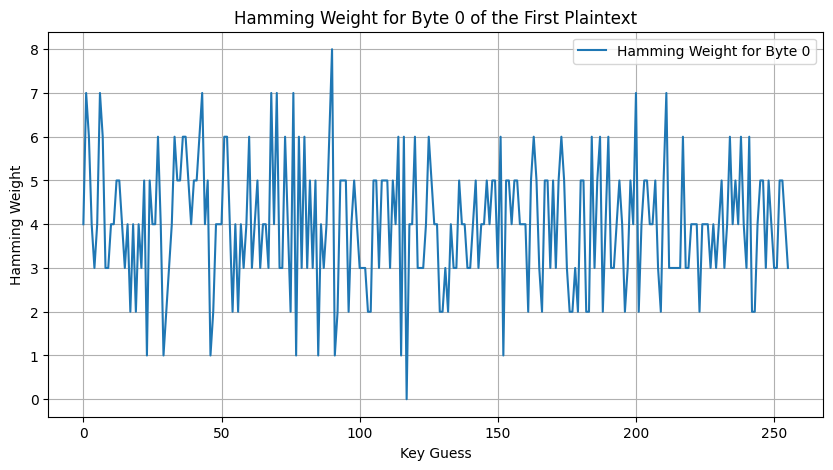

In [14]:
print(hamming_weights)
# Plotting Hamming weights for the first plaintext and the first key byte
plt.figure(figsize=(10, 5))
plt.plot(hamming_weights[0, 0, :], label='Hamming Weight for Byte 0')
plt.title('Hamming Weight for Byte 0 of the First Plaintext')
plt.xlabel('Key Guess')
plt.ylabel('Hamming Weight')
plt.legend()
plt.grid(True)
plt.show()


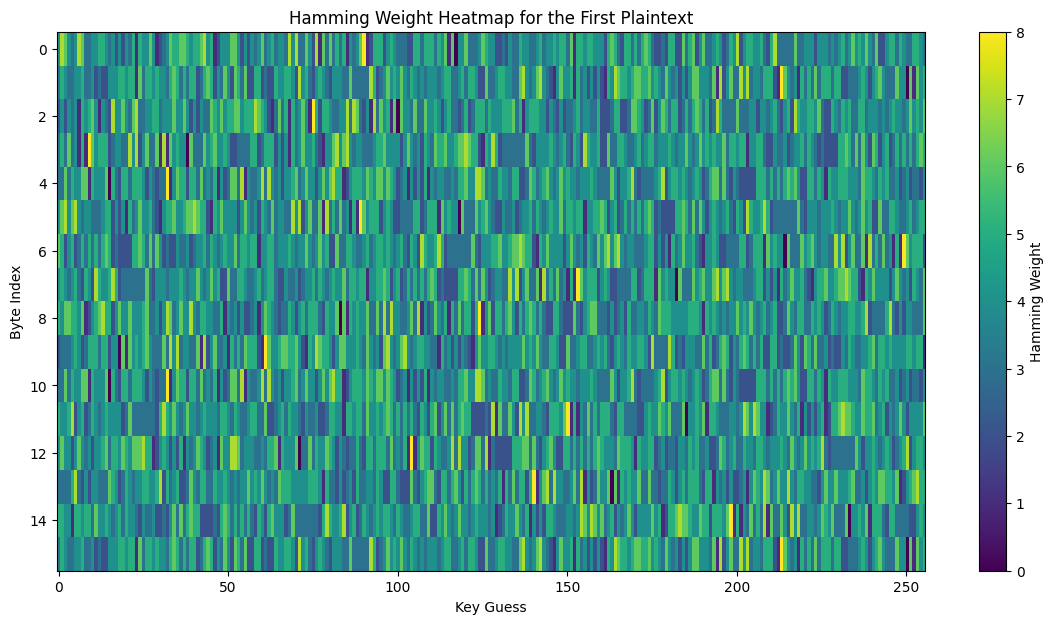

In [15]:
plt.figure(figsize=(14, 7))
# Assuming `hamming_weights` is indexed [plaintext_index, byte_index, key_guess]
# Heatmap of the Hamming weights for the first plaintext across all key bytes and key guesses
plt.imshow(hamming_weights[0, :, :], aspect='auto', cmap='viridis')
plt.colorbar(label='Hamming Weight')
plt.title('Hamming Weight Heatmap for the First Plaintext')
plt.xlabel('Key Guess')
plt.ylabel('Byte Index')
plt.show()

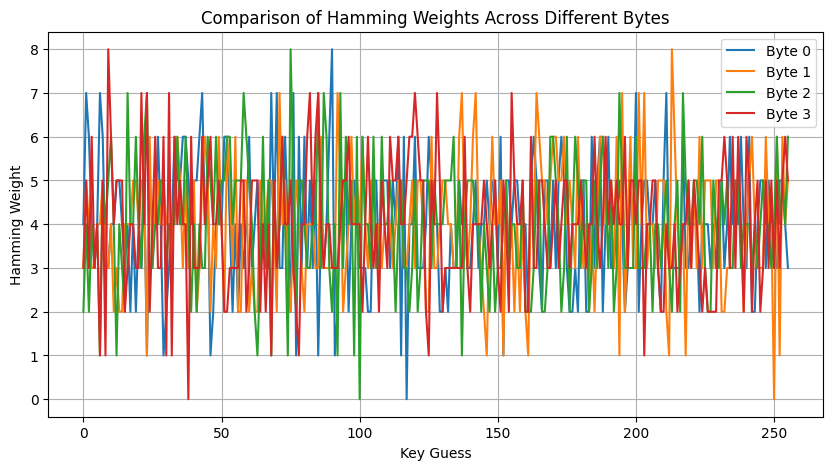

In [16]:
plt.figure(figsize=(10, 5))
# Plot for multiple bytes, change the range as needed
for i in range(4):  # Just plotting the first 4 bytes as an example
    plt.plot(hamming_weights[0, i, :], label=f'Byte {i}')

plt.title('Comparison of Hamming Weights Across Different Bytes')
plt.xlabel('Key Guess')
plt.ylabel('Hamming Weight')
plt.legend()
plt.grid(True)
plt.show()

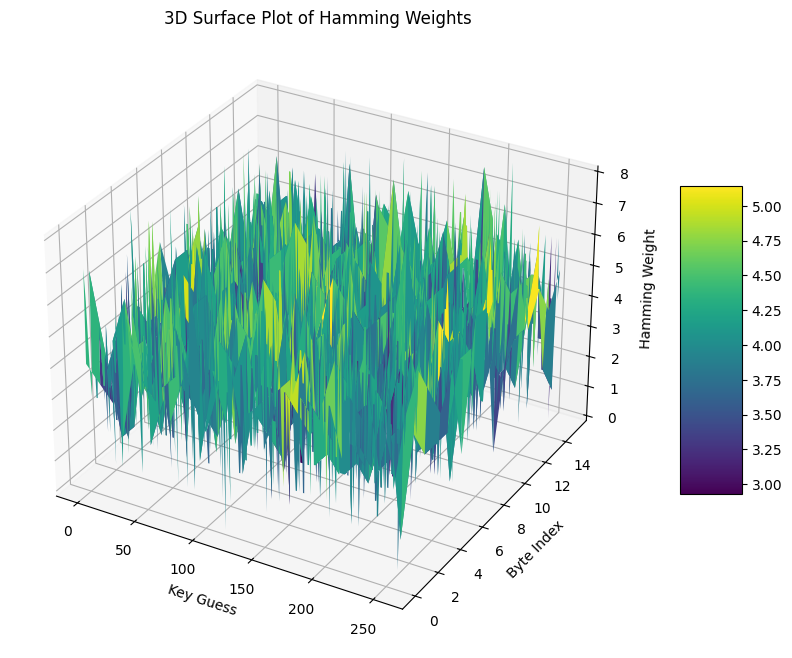

In [17]:
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(range(256), range(16))  # Key guesses and byte indices
Z = hamming_weights[0, :, :]  # Change indices as needed for different plaintexts

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_title('3D Surface Plot of Hamming Weights')
ax.set_xlabel('Key Guess')
ax.set_ylabel('Byte Index')
ax.set_zlabel('Hamming Weight')
plt.show()

In [19]:
from scipy.stats import pearsonr

# Correctly initialize the correlation matrix
max_correlations = np.zeros((16, 256))

# Process each key byte
for byte_index in range(16):
    print(byte_index)
    for key_guess in range(256):
        print(key_guess)
        # Extract the Hamming weight vector for the current key guess across all traces
        hamming_vector = hamming_weights[:, byte_index, key_guess]

        # Initialize a list to store correlation coefficients for current key guess across all samples
        correlation_coefficients = []

        # Compute correlation for each sample point across all traces
        for sample_index in range(50000):
            # Accessing trace sample vector correctly
            trace_sample_vector = all_traces[byte_index, :, sample_index]
            if len(hamming_vector) == len(trace_sample_vector):
                correlation, _ = pearsonr(hamming_vector, trace_sample_vector)
                correlation_coefficients.append(correlation)
            else:
                raise ValueError("The length of the hamming_vector does not match the length of the trace_sample_vector.")

        # Find the maximum correlation for this key guess
        max_correlations[byte_index, key_guess] = max(correlation_coefficients, default=0)  # Using default=0 to handle empty lists

# Identify the key guess with the highest correlation for each key byte
key = np.argmax(max_correlations, axis=1)
print("Suspected Key Bytes:", key)


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


KeyboardInterrupt: 